# Shear Estimator Plots

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import os.path
import astropy.table
import astropy.io.fits as fits

## Read Simulation Outputs

In [2]:
output_catalog_path = '..'
def locate(name): return os.path.join(output_catalog_path,'%s.fits' % name)

In [317]:
LSST_i = fits.open(locate('LSST_i_trimmed'))

In [320]:
LSST_r = fits.open(locate('LSST_r_trimmed'))

In [293]:
demo = fits.open(locate('demo'))

## Shear Measurement Errors

In [419]:
def shear_error_plots(results,save=None):
    hdr = results[0].header
    cat = astropy.table.Table.read(results,hdu=1)
    #
    psf_size = hdr['PSF_SIZE']
    print 'PSF size',psf_size,'arcsec'
    R = (cat['sigma_p']/psf_size)**2
    #
    visible = (cat['visible'] > 0)
    isolated = (cat['purity'] > 0.98)
    detected = (cat['snr_grpf'] > 6.)
    sample = visible & isolated & detected
    #
    fig = plt.figure(figsize=(9,5))
    nrow,ncol = 1,2
    #
    plt.subplot(nrow,ncol,1)
    plt.plot(1./cat['snr_iso'][sample],cat['dg1'][sample],'r+',label='$g_1$')
    plt.plot(1./cat['snr_iso'][sample],cat['dg2'][sample],'bx',label='$g_2$')
    plt.legend(loc='lower right')
    plt.xlabel('Inverse SNR $\\nu^{-1}_{iso}$')
    plt.ylabel('Isolated shear measurement error')
    plt.xlim(0,0.1)
    plt.ylim(0.,0.25)
    #
    plt.subplot(nrow,ncol,2)
    plt.plot(1./R[sample],cat['snr_iso'][sample]*cat['dg1'][sample],'r+',label='$g_1$')
    plt.plot(1./R[sample],cat['snr_iso'][sample]*cat['dg2'][sample],'bx',label='$g_2$')
    plt.legend(loc='upper left')
    #
    Rinv = np.linspace(0.,5.,100)
    error = 0.6*(1+(4.*Rinv)**0.55)
    plt.plot(Rinv,error,'yellow')
    #
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.ylim(0.,10.)
    plt.xlim(0.,5.)
    plt.ylim(0.,10.)
    plt.grid()

PSF size 0.605170282419 arcsec


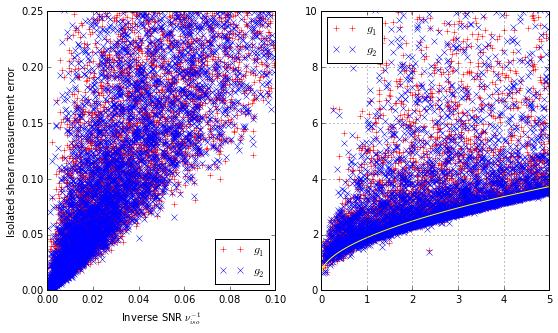

In [420]:
shear_error_plots(LSST_r)

## HSM Analysis

In [421]:
def hsm_plots(results,save=None):
    hdr = results[0].header
    cat = astropy.table.Table.read(results,hdu=1)
    # Calculate the simulated area in sq.arcmins.
    area = hdr['IMAGE_WIDTH'[-8:]]*hdr['IMAGE_HEIGHT'[-8:]]*hdr['PIXEL_SCALE'[-8:]]**2/3600.
    print 'Simulated area = %.3f sq.arcmins.' % area
    area_wgt = np.empty_like(cat['snr_sky'])
    area_wgt[:] = 1/area
    # Look up the PSF size in arcsecs.
    psf_size = hdr['PSF_SIZE']
    psf_size_hsm = hdr['HSM_SIZE']
    print 'PSF size = %.3f arcsec' % psf_size
    ratio = cat['psf_sigm']/psf_size
    # Calculate HSM success rate.
    ratio_ok = np.isfinite(cat['hsm_sigm'])
    shear_ok = np.isfinite(cat['hsm_e1']) & np.isfinite(cat['hsm_e2'])
    ntot = len(cat)
    print 'HSM found sizes (shears) for %.8f%% (%.8f%%) of galaxies.' % (
        1e2*np.count_nonzero(ratio_ok)/ntot,1e2*np.count_nonzero(shear_ok)/ntot)
    #
    visible = (cat['visible'] > 0)
    sample = ratio_ok & visible
    #
    figure = plt.figure(figsize=(8,8))
    nrow,ncol = 2,2
    #
    plt.subplot(nrow,ncol,1)
    bins=np.linspace(0.9,2.9,80)
    plt.hist(cat['hsm_sigm'][sample]/psf_size_hsm,bins=bins,weights=area_wgt[sample],histtype='stepfilled')
    plt.xlim(bins[0],bins[-1])
    plt.xlabel('HSM size ratio $\sigma_-^{psf*gal}/\sigma_-^{psf}$')
    plt.ylabel('Galaxies / sq.arcmin. / (%.3f)' % (bins[1]-bins[0]))
    #
    plt.subplot(nrow,ncol,2)
    xlo,xhi=0.25,1.
    plt.plot(cat['psf_sigm'][sample],cat['hsm_sigm'][sample],'+')
    plt.plot([xlo,xhi],[xlo,xhi],'r--')
    plt.xlabel('Catalog size (arcseconds)')
    plt.ylabel('HSM size (arcseconds)')
    plt.xlim(xlo,xhi)
    plt.ylim(xlo,xhi)
    #
    plt.subplot(nrow,ncol,3)
    bins=np.linspace(0.9,2.9,80)
    plt.hist(cat['psf_sigm'][sample]/psf_size,bins=bins,weights=area_wgt[sample],histtype='stepfilled')
    plt.xlim(bins[0],bins[-1])
    plt.xlabel('Catalog size ratio $\sigma_-^{psf*gal}/\sigma_-^{psf}$')
    plt.ylabel('Galaxies / sq.arcmin. / (%.3f)' % (bins[1]-bins[0]))
    #
    plt.subplot(nrow,ncol,4)
    xlo,xhi=0.95,2.
    plt.plot(cat['psf_sigm'][sample]/psf_size,cat['hsm_sigm'][sample]/psf_size_hsm,'+')
    plt.plot([xlo,xhi],[xlo,xhi],'r--')
    plt.xlim(xlo,xhi)
    plt.ylim(xlo,xhi)
    plt.xlabel('Catalog size ratio')
    plt.ylabel('HSM size ratio')
    #
    plt.tight_layout();
    if save is not None:
        plt.savefig(save+'.pdf')
        plt.savefig(save+'.png')

Simulated area = 186.414 sq.arcmins.
PSF size = 0.605 arcsec
HSM found sizes (shears) for 99.99558986% (99.70893054%) of galaxies.


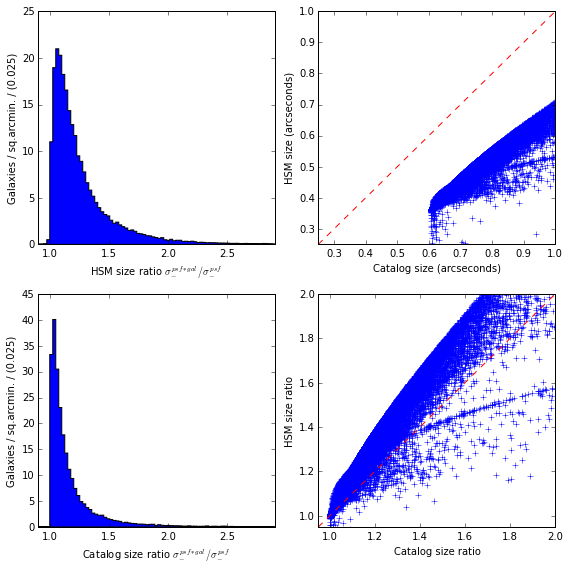

In [422]:
hsm_plots(LSST_r)

## Systematics Fitting Results

In [441]:
def fit_plots(results,save=None):
    hdr = results[0].header
    cat = astropy.table.Table.read(results,hdu=1)
    # Calculate the simulated area in sq.arcmins.
    area = hdr['IMAGE_WIDTH'[-8:]]*hdr['IMAGE_HEIGHT'[-8:]]*hdr['PIXEL_SCALE'[-8:]]**2/3600.
    print 'Simulated area = %.3f sq.arcmins.' % area
    area_wgt = np.empty_like(cat['snr_sky'])
    area_wgt[:] = 1/area
    #
    visible = cat['visible'] > 0
    detected = cat['snr_grpf'] > 6.
    blended = cat['grp_size'] > 1
    sample = detected & blended & visible
    g12 = np.hstack([cat['g1_fit'][sample],cat['g2_fit'][sample]])
    print 'mean(dg12)=',np.mean(g12),'rms(dg12)=',np.std(g12)
    #
    fig = plt.figure(figsize=(10,7))
    nrow,ncol = 2,2
    #
    plt.subplot(nrow,ncol,1)
    bins = np.linspace(-0.1,+0.1,40,endpoint=True)
    plt.hist(cat['g1_fit'][sample],range=(-0.04,+0.04),bins=bins,histtype='step',color='r',label='$\delta g_1$')
    plt.hist(cat['g2_fit'][sample],range=(-0.04,+0.04),bins=bins,histtype='step',color='b',label='$\delta g_2$')
    plt.xlim(bins[0],bins[-1])
    plt.xlabel('Shear offset $\delta g_{1,2}$')
    plt.yscale('log')
    plt.legend()
    #
    plt.subplot(nrow,ncol,2)
    plt.plot(cat['purity'][sample],cat['g1_fit'][sample],'r+',label='$\delta g_1$')
    plt.plot(cat['purity'][sample],cat['g2_fit'][sample],'bx',label='$\delta g_2$')
    plt.xlabel('Purity')
    plt.ylabel('Shear offset $\delta g_{1,2}$')
    plt.ylim(bins[0],bins[-1])
    plt.legend(loc='upper left')
    #
    plt.subplot(nrow,ncol,3)
    plt.plot(cat['g1_fit'][sample],cat['g2_fit'][sample],'k.',alpha=0.25)
    plt.xlim(bins[0],bins[-1])
    plt.ylim(bins[0],bins[-1])
    plt.xlabel('Shear offset $\delta g_1$')
    plt.ylabel('Shear offset $\delta g_2$')
    plt.grid()
    #
    plt.subplot(nrow,ncol,4)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (cat['purity'] >= xlo) & (cat['purity'] < xhi)
        dg1 = cat['g1_fit'][sample & in_range]
        dg2 = cat['g2_fit'][sample & in_range]
        n[i] = np.count_nonzero(sample & in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    #
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.grid()
    plt.xlabel('Purity')
    plt.ylabel('Shear offset covariance')
    #
    plt.tight_layout()

Simulated area = 186.414 sq.arcmins.
mean(dg12)= -0.000145969 rms(dg12)= 0.0139286
[ 0.02292992  0.02566059  0.01913998  0.00991596  0.01340589  0.02013011
  0.02155716  0.01516568  0.01895545  0.01822341  0.01725691  0.00828332]
[ 0.02378661  0.02492904  0.01678496  0.01277224  0.01906548  0.02032673
  0.01717878  0.01223529  0.02001156  0.02006171  0.01646148  0.00843428]
[-0.23985102 -0.52411025 -0.56291977 -0.23331614 -0.2406765  -0.13521881
 -0.575923   -0.25810687 -0.01389677 -0.09675879 -0.25315879 -0.35692738]


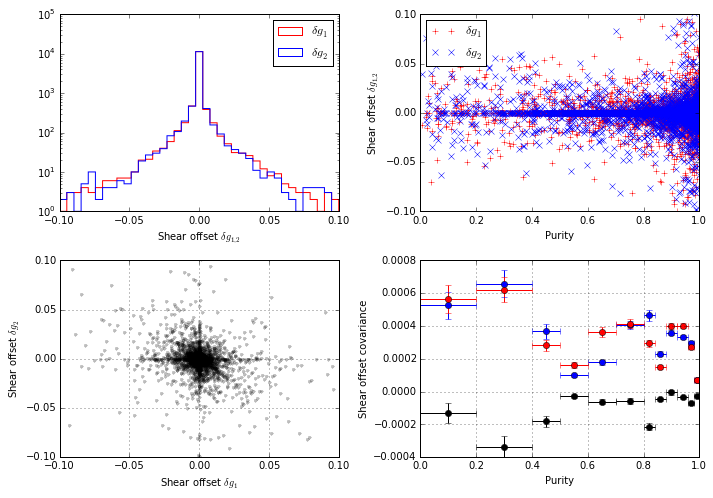

In [442]:
fit_plots(LSST_r)